# Exploratory Data Analysis
Smoothing parameters/ bimodality, & Momentum densities

In [78]:
import logging
import mmap
import h5py
import torch
from torch.utils.data import Dataset
import numpy as np
import os
import matplotlib as pyplt
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
from joblib import Parallel, delayed
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'iframe'

## 1. Extracting data
 (_Using modified code from RICHPID, Original author: Bob_)
 - File used: A/Run008548
 - No. of events: 128982
 

In [28]:
logger = logging.getLogger(__name__)

In [29]:
def compute_seq_id(hit, or_id=0):
    disk_id, pm_id, sc_id, up_dw_id, _ = hit
    """Compute the RICH PMT sequence ID"""
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return int(seq_id)

compute_seq_id = np.vectorize(compute_seq_id)

In [30]:
# Original Author: Bob ; modified for adding labels (ref: notebooks/input_data)
class RICHDataset(Dataset):
    """RICH pytorch dataset."""

    def check_dataset(self, name, obj):
        """ "Check the input file fromat."""
        if isinstance(obj, h5py.Dataset):
            print(name, obj.shape)
            print(name, obj.chunks)
            print(name, obj.compression)
            print(name, obj.dtype)
            # raise BadDataFormat('Unexpected data format, check the logs.')

    def __init__(
        self, dset_path, val_split, test_split, return_type="tensor", seed=None
    ):

        self.return_type = return_type

        if seed:
            np.random.seed(seed)

        # We don't attempt to catch exception here, crash if we cannot open the file.
        with h5py.File(dset_path, "r") as dfile:

            for key in dfile.attrs:
                logger.info("%s: %s", key, dfile.attrs[key])

            # We don't attempt to catch exception here,
            # crash if the data format is not what we were expecting.
            dfile.visititems(self.check_dataset)

            # Load the hit map into memory
            self.hit_mapping = np.asarray(dfile["HitMapping"][:])
            logger.info("hit map size: %i bytes", self.hit_mapping.nbytes)
            self.N = len(self.hit_mapping) - 1  # !!! The last cell is the sentinel !!!

            # Get the info we need to memory map the hits
            hit_ds = dfile["Hits"]
            hit_offset = hit_ds.id.get_offset()
            hit_dtype = hit_ds.dtype
            hit_shape = hit_ds.shape
            hit_length = np.prod(hit_shape)

            # Get the info we need to memory map the events
            event_ds = dfile["Events"]
            event_offset = event_ds.id.get_offset()
            event_dtype = event_ds.dtype
            event_shape = event_ds.shape
            event_length = np.prod(event_shape)

            # Add labels
            mu_off = dfile.attrs["muon_offset"]
            pi_off = dfile.attrs["pion_offset"]
            pos_off = dfile.attrs["positron_offset"]
            entries = dfile.attrs["entries"]

            # muon: 0, pion: 1, positron: 2
            self.labels = np.zeros(entries, dtype=np.int32)
            self.labels[mu_off:pi_off] = 0
            self.labels[pi_off:pos_off] = 1
            self.labels[pos_off:] = 2

            logger.info(f'Entries: {entries}')
            logger.info(f'Muons start at index: {mu_off}')
            logger.info(f'Pions start at index: {pi_off}')
            logger.info(f'Positron start at index: {pos_off}')

            # train test indices
            indices = np.arange(len(self))
            n_val = int(len(indices) * val_split)
            n_test = int(len(indices) * test_split)
            self.train_indices = indices[: -n_val - n_test]
            self.val_indices = indices[-n_test - n_val : -n_test]
            self.test_indices = indices[-n_test:]

        # We don't attempt to catch exception here, crash if we cannot open the file.
        with open(dset_path, "rb") as fh:
            fileno = fh.fileno()
            mapping = mmap.mmap(fileno, 0, access=mmap.ACCESS_READ)
            self.hit_array = np.frombuffer(
                mapping, dtype=hit_dtype, count=hit_length, offset=hit_offset
            ).reshape(hit_shape)
            logger.info("hit array mmap size: %i bytes", self.hit_array.nbytes)
            self.event_array = np.frombuffer(
                mapping, dtype=event_dtype, count=event_length, offset=event_offset
            ).reshape(event_shape)
            logger.info("event array mmap size: %i bytes", self.event_array.nbytes)

    def get_position_data(self):
        return np.load(os.path.join("../tools", "rich_pmt_positions.npy"))

    def get_event_pos(self, idx):

        # get hits
        idx_from = self.hit_mapping[idx]
        idx_to = self.hit_mapping[idx + 1]
        hits = self.hit_array[idx_from:idx_to]

        # load position map data
        position_map = self.get_position_data()

        # create index
        index = compute_seq_id(hits)
        event_pos = position_map[index]

        return event_pos

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            raise NotImplementedError(f"{type(idx)} type key access is not implemented")
        if idx < 0:
            raise NotImplementedError("negative index access is not implemented")

        idx_from = self.hit_mapping[idx]
        idx_to = self.hit_mapping[idx + 1]

        # prepare data
        event_pos = self.get_event_pos(idx)
        labels = self.labels[idx]
        hit_time = self.hit_array[idx_from:idx_to]["hit_time"]
        chod_time = self.event_array[idx]["chod_time"]
        track_momentum = self.event_array[idx]["track_momentum"]
        ring_radius = self.event_array[idx]["ring_radius"]

        if self.return_type == "numpy":
            return {
                "event_pos": event_pos,
                "label": labels,
                "hit_time": hit_time,
                "chod_time": chod_time,
                "track_momentum": track_momentum,
                "ring_radius": ring_radius,
            }
        elif self.return_type == "tensor":
            return {
                "event_pos": torch.tensor(event_pos),
                "label": torch.tensor(labels),
                "hit_time": torch.tensor(hit_time),
                "chod_time": torch.tensor(chod_time),
                "track_momentum": torch.tensor(track_momentum),
                "ring_radius": torch.tensor(ring_radius),
            }


In [31]:
# Reading in data from /data/bvelghe/capstone2022/A/ using dataloader RICHDataset
dset_path = "/data/bvelghe/capstone2022/A/Run008548.EOSlist.CTRL.p.v2.0.4-01_f.v2.0.4-01.h5"
dset = RICHDataset(
    dset_path,
    val_split=0.1, 
    test_split=0.1, 
    return_type="tensor"
)

Events (128982,)
Events None
Events None
Events {'names': ['run_id', 'burst_id', 'event_id', 'track_id', 'track_momentum', 'chod_time', 'ring_radius', 'ring_centre_pos', 'ring_likelihood'], 'formats': ['<i4', '<i4', '<i8', '<i4', '<f4', '<f4', '<f4', ('<f4', (2,)), ('<f4', (3,))], 'offsets': [0, 4, 8, 16, 20, 24, 28, 32, 40], 'itemsize': 56}
HitMapping (128983,)
HitMapping (128982,)
HitMapping gzip
HitMapping int64
Hits (4689741,)
Hits None
Hits None
Hits [('disk_id', '<i4'), ('pmt_id', '<i4'), ('supercell_id', '<i4'), ('updowndisk_id', '<i4'), ('hit_time', '<f4')]


In [32]:
# Fetching offsets and no. of events (entries)
dfile = h5py.File(dset_path, 'r')
mu_off = dfile.attrs["muon_offset"]
pi_off = dfile.attrs["pion_offset"]
pos_off = dfile.attrs["positron_offset"]
entries = dfile.attrs["entries"]

## 3. EDA Objectives 

We have already done preliminary exploratory data analysis, wherein we observed a lot of noise in the hits data (variable length array). So, our post preliminary EDA, our key goals are as follows:

### 3.1 Filtering the noise in hits data

To achieve this, we explored hit times ~ chod times delta. Note: While we understand that pointnet/ GCNN, may be able to handle this implicitly, but we might need this for further improving metrics. 

From https://github.com/TRIUMF-Capstone2022/RICHPID/blob/main/docs/slides/intro_data_apr8_v0.pdf, 
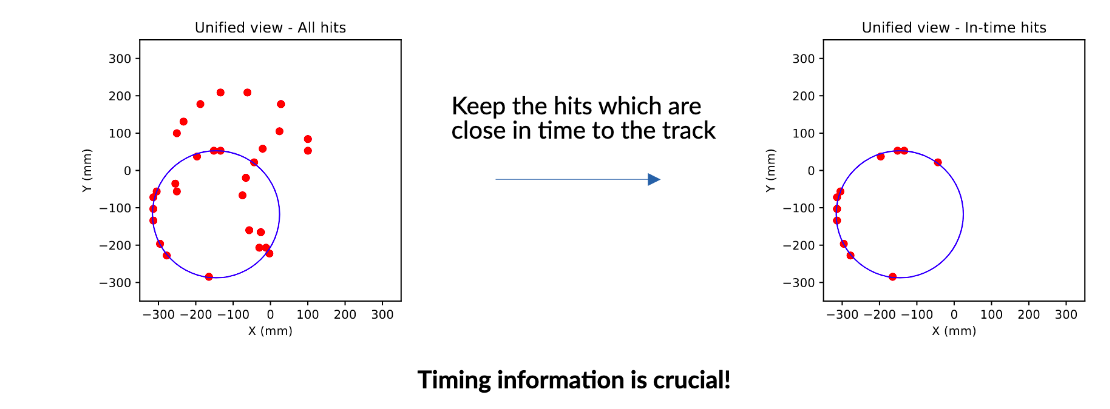

### 3.1.1 A single event (muon)

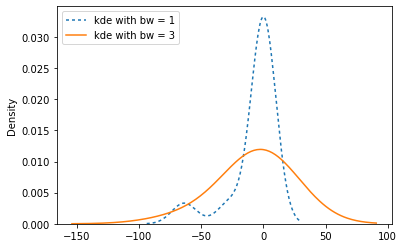

In [103]:
# Resolving the smoothing issue
fig = sns.kdeplot(ht_muon, bw_adjust=1, label = "kde with bw = 1", x = 'delta (ns)', dashes = (2,2))
fig = sns.kdeplot(ht_muon, bw_adjust=3, label = "kde with bw = 3")
plt.legend()
plt.show()

### 3.1.2 Densities of delta (hit time - chod time) for 1000 events

#### n = 1000 Events

In [40]:
# Sample size
n = 1000

In [41]:
# Defining function for delta
def delta(i):
    return (dset[i]['hit_time'] - dset[i]['chod_time']).numpy().mean()

In [81]:
# Defining function for randomly sampling indices
def get_idx(n, offset, seed=123):
    """Returns randomly sampled list of indices"""
    np.random.seed(seed)
    idx_start = offset
    idx_end = offset + n

    idx_list = np.random.choice(
        range(idx_start, idx_end),
        n, 
        replace = False
    )
    return idx_list

In [91]:
# Muons: 
pi_off - mu_off

115340

In [92]:
# Pions
pos_off - pi_off

12471

In [93]:
# Positrons
entries - 1 - pos_off

1170

In [90]:
# Getting 1000, 10,000 indices (Except pion which has only 1170 events)
# Muons
idx_list_muon_1000 = get_idx(1000, mu_off, pi_off)
idx_list_muon_10_000 = get_idx(10000, mu_off, pi_off)

# Pions
idx_list_pion_1000 = get_idx(1000, pi_off, pos_off)
idx_list_pion_10_000 = get_idx(10000, pi_off, pos_off)

# Positrons
idx_list_positron_1000 = get_idx(1000, pos_off, entries - 1)

In [83]:
# Getting delta for the sampled events - muons
delta_muon_A_1000 = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_muon_1000)
delta_muon_A_10_000 = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_muon_10_000)

In [87]:
# Getting delta for the sampled events - pions
delta_pion_A_1000 = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_pion_1000)
delta_pion_A_10_000 = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_pion_10_000)

In [94]:
# Getting delta for the sampled events - positrons
delta_positron_A_1000 = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_positron_1000)

In [95]:
# Add histogram data

# Group data together
hist_data = [
    delta_muon_A_1000, delta_muon_A_10_000,
    delta_pion_A_1000, delta_pion_A_10_000,
    delta_positron_A_1000
]
group_labels = [
    '1000 muon events', '10,000 muon events',
    '1000 pion events', '10,000 pion events',
    '1000 positron events'
]

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=2, curve_type="normal", )
fig.update_layout(
    title_text=f'Distplots of randomly sampled delta (hit time - chod time) for 1,000 & 10,000 events',
    
)
fig.show()

### 90 % cut-off

In [113]:
# Muons
mean_ = np.mean(delta_muon_A_10_000)
sd_ = np.std(delta_muon_A_10_000)
print((mean_ - 1.645 * sd_, mean_ + 1.645 * sd_))

(-22.053754959106445, 19.965875062942505)


In [114]:
# Pions
mean_ = np.mean(delta_pion_A_10_000)
sd_ = np.std(delta_pion_A_10_000)
print((mean_ - 1.645 * sd_, mean_ + 1.645 * sd_))

(-28.065075974464417, 24.210910420417786)


In [115]:
# Positrons
mean_ = np.mean(delta_positron_A_1000)
sd_ = np.std(delta_positron_A_1000)
print((mean_ - 1.645 * sd_, mean_ + 1.645 * sd_))

(-27.169797368049622, 24.202773756980896)


In [75]:
delta_muon_A = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_muon_n)

In [76]:
delta_muon_A_10000 = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_muon_10000)

NameError: name 'idx_list_muon_10000' is not defined

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launch

## 4. Momentum

***Sample size: n = 1000 events***

### 4.1 Muon events

In [18]:
# Defining function for momentum
def momentum(i):
    return (dset[i]['track_momentum'].numpy())

In [19]:
# Parallelising (currently for 1000 muon events)
p_muon_A = Parallel(n_jobs=-1)(delayed(momentum)(int(i)) for i in idx_list_muon_n)

### 4.2 Pion Events

In [21]:
# Getting indexes 
idx_list_pion_n = get_idx(n, pi_off)[:-1]  # Removing the sentinel value

In [22]:
# Parallelising for 1000 pion events
p_pion_A = Parallel(n_jobs=-1)(delayed(momentum)(int(i)) for i in idx_list_pion_n)

### 4.3 Positron events

In [24]:
# Getting indexes 
idx_list_pos_n = get_idx(n, pos_off)

In [25]:
# Parallelising 
p_pos_A = Parallel(n_jobs=-1)(delayed(momentum)(int(i)) for i in idx_list_pos_n)

### 4.4 Overlay of momentum density plots all three particles for n = 1000 each

In [96]:
# Add histogram data
sample_muon = np.asarray(p_muon_A)
sample_pion = np.asarray(p_pion_A)
sample_positron = np.asarray(p_pos_A)

# Group data together
hist_data = [sample_muon, sample_pion, sample_positron]
group_labels = ['muon', 'pion', 'positron']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=[2,4,5,10], curve_type="normal")
fig.update_layout(
    title_text=f'Distplots of sampled particles (n = {n}) with Normal Distribution',
    
)
fig.show()

#### Key findings:
1. There are visible differences in the distributions of momentum of the three particles. While positron is clearly separated, Muon and pion are not that much separated by momentum values.
2. We understand, from the ring radius ~ track momentum plot from other eda notebooks, the particles are 
 - fairly separable in lower momentum bins, 
 - less separable in medium, and 
 - almost inseparable in higher momentum bins. 
 
Therefore, identifying cut-off momentum could be key to investigate further.

One possible approach: consider an alpha range of [0.001, 0.01, 0.05], and find a cut-off point based on z values.